<a href="https://colab.research.google.com/github/Megancodes2017/Megancodes2017/blob/main/Framber_Valdez_SIERA_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.4 MB/s eta 0:00:00


In [2]:
from pybaseball import pitching_stats, statcast_pitcher, playerid_lookup
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import xgboost as XGBRegressor

In [3]:
# Pull 7 years of pitcher data
data = pd.concat([pitching_stats(y) for y in range(2019, 2026)], ignore_index=True)

# Keep relevant columns
cols = ['Season', 'Name', 'Team', 'Age', 'IP', 'K%', 'BB%', 'GB%', 'FB%', 'LD%', 'ERA', 'FIP', 'xFIP', 'SIERA']
data = data[cols]

# Drop small samples
data = data[data['IP'] > 30]

# Sort by player/year
data.sort_values(['Name', 'Season'], inplace=True)

In [4]:
# Create year to year target (SIERA_next)
data['SIERA_next'] = data.groupby('Name')['SIERA'].shift(-1)
data = data.dropna(subset=['SIERA_next'])

In [5]:
# Feature engineering
for col in ['K%', 'BB%', 'GB%', 'FB%', 'LD%']:
  data[f'delta_{col}'] = data.groupby('Name')[col].diff()

data = data.dropna(subset=['delta_K%', 'delta_BB%', 'delta_GB%', 'delta_FB%', 'delta_LD%'])

In [6]:
# Train model to predict SIERA_next
features = ['Age', 'IP', 'K%', 'BB%', 'GB%', 'FB%', 'LD%', 'ERA', 'FIP', 'xFIP', 'delta_K%', 'delta_BB%', 'delta_GB%', 'delta_FB%', 'delta_LD%']

X = data[features]
y = data['SIERA_next']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=400, learning_rate=0.03, max_depth=4)
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print('Validation RMSE:', round(rmse, 3))

Validation RMSE: 0.5


In [7]:
# Framber Valdez 2025 stats
framber = data[data['Name'] == 'Framber Valdez'].sort_values('Season').iloc[-1]

predictions = []
current = framber.copy()

for year in range(2026, 2031):
  X_pred = current[features].to_frame().T
  siera_pred = model.predict(X_pred)[0]
  predictions.append({'Season': year, 'Predicted_SIERA': siera_pred})

  # Update features slightly for next year
  current['Age'] += 1
  current['K%'] *= 0.99   # 1% annual decline
  current['BB%'] *= 1.01  # slight increase
  current['GB%'] *= 0.995 # small regression
  current['FB%'] *= 1.01
  current['LD%'] *= 1.005
  current['ERA'] = siera_pred


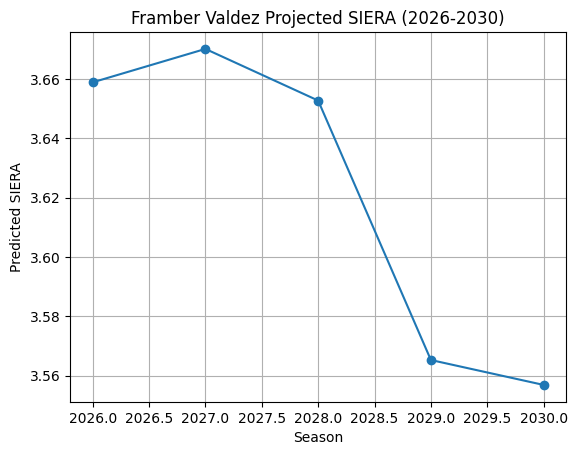


Framber Valdez Projected SIERA (2026-2030):
   Season  Predicted_SIERA
0    2026         3.658829
1    2027         3.670088
2    2028         3.652681
3    2029         3.565223
4    2030         3.556825


In [8]:
# Visualize
pred_df = pd.DataFrame(predictions)

plt.plot(pred_df['Season'], pred_df['Predicted_SIERA'], marker='o')
plt.title('Framber Valdez Projected SIERA (2026-2030)')
plt.xlabel('Season')
plt.ylabel('Predicted SIERA')
plt.grid(True)
plt.show()

print("\nFramber Valdez Projected SIERA (2026-2030):")
print(pred_df)

In [9]:
# Compare with XGBoost model
xgb_model = XGBRegressor.XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

print(f"Gradident Boosting RMSE: {rmse:.3f}")
print(f"XGBoost RMSE: {xgb_rmse:.3f}")

Gradident Boosting RMSE: 0.500
XGBoost RMSE: 0.510
